In [126]:
import requests
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time

In [127]:
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=max&interval=daily"
response = requests.get(url)
data = response.json()

In [128]:
df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
df.drop('timestamp', axis=1, inplace=True)

In [129]:
df.drop(df.index[-1], axis = 0, inplace=True)

In [130]:
df['progression daily']=0

In [131]:
df

,price,date,progression daily
0,135.300000,2013-04-28,0
1,141.960000,2013-04-29,0
2,135.300000,2013-04-30,0
3,117.000000,2013-05-01,0
4,103.430000,2013-05-02,0
...,...,...,...
3817,26842.190439,2023-10-12,0
3818,26729.137206,2023-10-13,0
3819,26841.136221,2023-10-14,0
3820,26863.183569,2023-10-15,0


In [132]:
#Progression daily : improvement on the previous day
for i in range(df.shape[0] - 1):
      df.loc[i+1, 'progression daily'] = (df['price'][i+1] / df['price'][i]) - 1

C:\Users\thoma\AppData\Local\Temp\ipykernel_4644\3522090179.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.04922394678492226' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i+1, 'progression daily'] = (df['price'][i+1] / df['price'][i]) - 1


In [133]:
df

,price,date,progression daily
0,135.300000,2013-04-28,0.000000
1,141.960000,2013-04-29,0.049224
2,135.300000,2013-04-30,-0.046915
3,117.000000,2013-05-01,-0.135255
4,103.430000,2013-05-02,-0.115983
...,...,...,...
3817,26842.190439,2023-10-12,-0.020081
3818,26729.137206,2023-10-13,-0.004212
3819,26841.136221,2023-10-14,0.004190
3820,26863.183569,2023-10-15,0.000821


In [134]:
#Progression daily : improvement on the next day (predict target)

df['progression tomorrow']=0.0
for i in range(df.shape[0] - 1):
      df.loc[i, 'progression tomorrow'] = (df['price'][i+1] / df['price'][i]) - 1

In [135]:
df

,price,date,progression daily,progression tomorrow
0,135.300000,2013-04-28,0.000000,0.049224
1,141.960000,2013-04-29,0.049224,-0.046915
2,135.300000,2013-04-30,-0.046915,-0.135255
3,117.000000,2013-05-01,-0.135255,-0.115983
4,103.430000,2013-05-02,-0.115983,-0.120081
...,...,...,...,...
3817,26842.190439,2023-10-12,-0.020081,-0.004212
3818,26729.137206,2023-10-13,-0.004212,0.004190
3819,26841.136221,2023-10-14,0.004190,0.000821
3820,26863.183569,2023-10-15,0.000821,0.010688


In [136]:
#Fear and greed index

# URL de base
base_url = "https://api.alternative.me"

# Endpoint pour le Fear and Greed Index
endpoint = "/fng/"

# Paramètres
params = {
    "limit": "0",  # obtenir toutes les données disponibles
    "format": "json",  # format des données
    "date_format": "world"  # format de la date
}

# Faire la requête
response = requests.get(base_url + endpoint, params=params)

# Vérifier si la requête a réussi
if response.status_code == 200:
    data = response.json()["data"]
    df_fng = pd.DataFrame(data)
else:
    print(f"Erreur {response.status_code}: {response.text}")

In [137]:
df_fng.drop(df_fng.columns[-1], axis=1, inplace=True)

In [138]:
df_fng

,value,value_classification,timestamp
0,47,Neutral,16-10-2023
1,45,Fear,15-10-2023
2,47,Neutral,14-10-2023
3,44,Fear,13-10-2023
4,45,Fear,12-10-2023
...,...,...,...
2076,11,Extreme Fear,05-02-2018
2077,24,Extreme Fear,04-02-2018
2078,40,Fear,03-02-2018
2079,15,Extreme Fear,02-02-2018


In [139]:
# Convertir la colonne 'date' en datetime pour les deux DataFrames
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df_fng['date'] = pd.to_datetime(df_fng['timestamp'], dayfirst=True)

# Fusionner les deux DataFrames sur la colonne 'date'
df_merged = df.merge(df_fng, on='date', how='left')

In [140]:
df_merged

,price,date,progression daily,progression tomorrow,value,value_classification,timestamp
0,135.300000,2013-04-28,0.000000,0.049224,NaN,NaN,NaN
1,141.960000,2013-04-29,0.049224,-0.046915,NaN,NaN,NaN
2,135.300000,2013-04-30,-0.046915,-0.135255,NaN,NaN,NaN
3,117.000000,2013-05-01,-0.135255,-0.115983,NaN,NaN,NaN
4,103.430000,2013-05-02,-0.115983,-0.120081,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3817,26842.190439,2023-10-12,-0.020081,-0.004212,45,Fear,12-10-2023
3818,26729.137206,2023-10-13,-0.004212,0.004190,44,Fear,13-10-2023
3819,26841.136221,2023-10-14,0.004190,0.000821,47,Neutral,14-10-2023
3820,26863.183569,2023-10-15,0.000821,0.010688,45,Fear,15-10-2023


In [141]:
'''import requests
import json

# URL de l'endpoint GraphQL de Bitquery
url = "https://graphql.bitquery.io/"

# Votre requête GraphQL
query = """
{
  bitcoin(network: bitcoin) {
    blocks(time: {since: "2013-04-28T00:00:00Z", till: "2013-05-01T00:00:00Z"}) {
      timestamp {
        time(format: "%Y-%m-%d %H:%M:%S")
      }
      difficulty
    }
  }
}
"""

# Headers de la requête
headers = {
    "Content-Type": "application/json",
    "X-API-KEY": ""
}

# Effectuer la requête
response = requests.post(url, headers=headers, data=json.dumps({"query": query}))

# Vérifier si la requête a réussi
if response.status_code == 200:
    # Afficher les données retournées par l'API
    print(json.dumps(response.json(), indent=2))
else:
    # Afficher l'erreur
    print("Erreur :", response.status_code)
    print(response.text)'''

'import requests\nimport json\n\n# URL de l\'endpoint GraphQL de Bitquery\nurl = "https://graphql.bitquery.io/"\n\n# Votre requête GraphQL\nquery = """\n{\n  bitcoin(network: bitcoin) {\n    blocks(time: {since: "2013-04-28T00:00:00Z", till: "2013-05-01T00:00:00Z"}) {\n      timestamp {\n        time(format: "%Y-%m-%d %H:%M:%S")\n      }\n      difficulty\n    }\n  }\n}\n"""\n\n# Headers de la requête\nheaders = {\n    "Content-Type": "application/json",\n    "X-API-KEY": ""\n}\n\n# Effectuer la requête\nresponse = requests.post(url, headers=headers, data=json.dumps({"query": query}))\n\n# Vérifier si la requête a réussi\nif response.status_code == 200:\n    # Afficher les données retournées par l\'API\n    print(json.dumps(response.json(), indent=2))\nelse:\n    # Afficher l\'erreur\n    print("Erreur :", response.status_code)\n    print(response.text)'

In [142]:
'''# Dates de début et de fin
start_date = datetime.strptime("2013-04-28", "%Y-%m-%d")
end_date = datetime.now()

# Créer un DataFrame pour stocker les données
data = []

# Boucle sur chaque jour entre start_date et end_date
current_date = start_date
while current_date <= end_date:
    # Convertir les dates en chaînes de caractères au format ISO 8601
    since = current_date.strftime("%Y-%m-%dT%H:%M:%SZ")
    till = (current_date + timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%SZ")
    
    # Votre requête GraphQL
    query = f"""
    {{
      bitcoin(network: bitcoin) {{
        blocks(time: {{since: "{since}", till: "{till}"}}) {{
          timestamp {{
            time(format: "%Y-%m-%d %H:%M:%S")
          }}
          difficulty
        }}
      }}
    }}
    """"""
    
    # Effectuer la requête
    response = requests.post(url, headers=headers, data=json.dumps({"query": query}))
    
    # Vérifier si la requête a réussi
    if response.status_code == 200:
      # Extraire les données
      blocks = response.json()['data']['bitcoin']['blocks']
      if blocks:
          # Ajouter les données au DataFrame
          for block in blocks:
              data.append([block['timestamp']['time'], block['difficulty']])
    elif response.status_code == 429:
        # Attendre et réessayer
        print("Trop de requêtes, en attente...")
        time.sleep(10)  # Attendre 10 secondes avant de réessayer
        continue  # Réessayer la même requête
    else:
        # Afficher l'erreur
        print("Erreur :", response.status_code)
        print(response.text)
    
    # Passer au jour suivant
    current_date += timedelta(days=1)
    
    # Attendre avant la prochaine requête pour éviter de dépasser la limite de taux
    time.sleep(1)  # Attendre 1 seconde avant la prochaine requête

# Convertir les données en DataFrame
dif = pd.DataFrame(data, columns=['timestamp', 'difficulty'])

# Afficher le DataFrame
print(dif)'''

'# Dates de début et de fin\nstart_date = datetime.strptime("2013-04-28", "%Y-%m-%d")\nend_date = datetime.now()\n\n# Créer un DataFrame pour stocker les données\ndata = []\n\n# Boucle sur chaque jour entre start_date et end_date\ncurrent_date = start_date\nwhile current_date <= end_date:\n    # Convertir les dates en chaînes de caractères au format ISO 8601\n    since = current_date.strftime("%Y-%m-%dT%H:%M:%SZ")\n    till = (current_date + timedelta(days=1)).strftime("%Y-%m-%dT%H:%M:%SZ")\n    \n    # Votre requête GraphQL\n    query = f"""\n    {{\n      bitcoin(network: bitcoin) {{\n        blocks(time: {{since: "{since}", till: "{till}"}}) {{\n          timestamp {{\n            time(format: "%Y-%m-%d %H:%M:%S")\n          }}\n          difficulty\n        }}\n      }}\n    }}\n    """"""\n    \n    # Effectuer la requête\n    response = requests.post(url, headers=headers, data=json.dumps({"query": query}))\n    \n    # Vérifier si la requête a réussi\n    if response.status_code 

In [143]:
from datetime import datetime, timedelta
import time
import requests
import json
import pandas as pd

'''# Dates de début et de fin
start_date = datetime.strptime("2013-04-28", "%Y-%m-%d")
end_date = datetime.now()

# Créer un DataFrame pour stocker les données
data = []
nb = 0

# Boucle sur chaque jour entre start_date et end_date
current_date = start_date
while current_date <= end_date:
    # Convertir les dates en chaînes de caractères au format ISO 8601
    since = current_date.strftime("%Y-%m-%dT00:00:00Z")  # Minuit du jour courant
    till = (current_date + timedelta(hours=2)).strftime("%Y-%m-%dT02:00:00Z")  # 02 du jour courant
    
    # Votre requête GraphQL
    query = f"""
    {{
      bitcoin(network: bitcoin) {{
        blocks(time: {{since: "{since}", till: "{till}"}}) {{
          timestamp {{
            time(format: "%Y-%m-%d %H:%M:%S")
          }}
          difficulty
        }}
      }}
    }}
    """
    
    # Effectuer la requête
    response = requests.post(url, headers=headers, data=json.dumps({"query": query}))
    
    # Vérifier si la requête a réussi
    if response.status_code == 200:
        # Extraire les données
        blocks = response.json()['data']['bitcoin']['blocks']
        if blocks:
            # Ajouter les données au DataFrame
            block = blocks[0]
            data.append([block['timestamp']['time'], block['difficulty']])
    elif response.status_code == 429:
        # Attendre et réessayer
        print("Trop de requêtes, en attente...")
        time.sleep(10)  # Attendre 10 secondes avant de réessayer
        continue  # Réessayer la même requête
    else:
        # Afficher l'erreur
        print("Erreur :", response.status_code)
        print(response.text)
    
    # Passer au jour suivant
    current_date += timedelta(days=1)
    nb += 1
    print(nb)
    print(data)
    
    # Attendre avant la prochaine requête pour éviter de dépasser la limite de taux
    time.sleep(1)  # Attendre 1 seconde avant la prochaine requête

# Convertir les données en DataFrame
dif = pd.DataFrame(data, columns=['timestamp', 'difficulty'])

# Afficher le DataFrame
print(dif)'''

'# Dates de début et de fin\nstart_date = datetime.strptime("2013-04-28", "%Y-%m-%d")\nend_date = datetime.now()\n\n# Créer un DataFrame pour stocker les données\ndata = []\nnb = 0\n\n# Boucle sur chaque jour entre start_date et end_date\ncurrent_date = start_date\nwhile current_date <= end_date:\n    # Convertir les dates en chaînes de caractères au format ISO 8601\n    since = current_date.strftime("%Y-%m-%dT00:00:00Z")  # Minuit du jour courant\n    till = (current_date + timedelta(hours=2)).strftime("%Y-%m-%dT02:00:00Z")  # 02 du jour courant\n    \n    # Votre requête GraphQL\n    query = f"""\n    {{\n      bitcoin(network: bitcoin) {{\n        blocks(time: {{since: "{since}", till: "{till}"}}) {{\n          timestamp {{\n            time(format: "%Y-%m-%d %H:%M:%S")\n          }}\n          difficulty\n        }}\n      }}\n    }}\n    """\n    \n    # Effectuer la requête\n    response = requests.post(url, headers=headers, data=json.dumps({"query": query}))\n    \n    # Vérifie

In [144]:
"""
dif['timestamp'] = pd.to_datetime(dif['timestamp'])

dif['timestamp'] = dif['timestamp'].dt.strftime('%Y-%m-%d')

dif.to_csv('data/dif')"""

"\ndif['timestamp'] = pd.to_datetime(dif['timestamp'])\n\ndif['timestamp'] = dif['timestamp'].dt.strftime('%Y-%m-%d')\n\ndif.to_csv('data/dif')"

In [145]:
dif = pd.read_csv('data/dif', index_col=0)
dif

,timestamp,difficulty
0,2013-04-28,8.974296e+06
1,2013-04-29,8.974296e+06
2,2013-04-30,8.974296e+06
3,2013-05-01,1.007629e+07
4,2013-05-02,1.007629e+07
...,...,...
3815,2023-10-08,5.732151e+13
3816,2023-10-09,5.732151e+13
3817,2023-10-10,5.732151e+13
3818,2023-10-11,5.732151e+13


In [146]:
# Convertir la colonne 'date' en datetime pour les deux DataFrames
dif['date'] = pd.to_datetime(dif['timestamp'], dayfirst=True)

# Fusionner les deux DataFrames sur la colonne 'date'
df_merged = df_merged.merge(dif, on='date', how='left')

C:\Users\thoma\AppData\Local\Temp\ipykernel_4644\1659043105.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dif['date'] = pd.to_datetime(dif['timestamp'], dayfirst=True)


In [147]:
df_merged

,price,date,progression daily,progression tomorrow,value,value_classification,timestamp_x,timestamp_y,difficulty
0,135.300000,2013-04-28,0.000000,0.049224,NaN,NaN,NaN,2013-04-28,8.974296e+06
1,141.960000,2013-04-29,0.049224,-0.046915,NaN,NaN,NaN,2013-04-29,8.974296e+06
2,135.300000,2013-04-30,-0.046915,-0.135255,NaN,NaN,NaN,2013-04-30,8.974296e+06
3,117.000000,2013-05-01,-0.135255,-0.115983,NaN,NaN,NaN,2013-05-01,1.007629e+07
4,103.430000,2013-05-02,-0.115983,-0.120081,NaN,NaN,NaN,2013-05-02,1.007629e+07
...,...,...,...,...,...,...,...,...,...
3817,26842.190439,2023-10-12,-0.020081,-0.004212,45,Fear,12-10-2023,2023-10-12,5.732151e+13
3818,26729.137206,2023-10-13,-0.004212,0.004190,44,Fear,13-10-2023,NaN,NaN
3819,26841.136221,2023-10-14,0.004190,0.000821,47,Neutral,14-10-2023,NaN,NaN
3820,26863.183569,2023-10-15,0.000821,0.010688,45,Fear,15-10-2023,NaN,NaN


In [148]:
volume = pd.read_json('data/trade-volume.json')

In [150]:
volume

,metric1,metric2,trade-volume,market-price,type,average,timespan
0,trade-volume,market-price,"{'x': 1230940800000, 'y': 0}","{'x': 1230940800000, 'y': 0}",linear,1d,all
1,trade-volume,market-price,"{'x': 1231286400000, 'y': 0}","{'x': 1231286400000, 'y': 0}",linear,1d,all
2,trade-volume,market-price,"{'x': 1231632000000, 'y': 0}","{'x': 1231632000000, 'y': 0}",linear,1d,all
3,trade-volume,market-price,"{'x': 1231977600000, 'y': 0}","{'x': 1231977600000, 'y': 0}",linear,1d,all
4,trade-volume,market-price,"{'x': 1232323200000, 'y': 0}","{'x': 1232323200000, 'y': 0}",linear,1d,all
...,...,...,...,...,...,...,...
1344,trade-volume,market-price,"{'x': 1695427200000, 'y': 60729980.630399995}","{'x': 1695427200000, 'y': 26581.86}",linear,1d,all
1345,trade-volume,market-price,"{'x': 1695772800000, 'y': 56123482.517400004}","{'x': 1695772800000, 'y': 26212.82}",linear,1d,all
1346,trade-volume,market-price,"{'x': 1696118400000, 'y': 33571712.4468}","{'x': 1696118400000, 'y': 26970.43}",linear,1d,all
1347,trade-volume,market-price,"{'x': 1696464000000, 'y': 98113433.84920001}","{'x': 1696464000000, 'y': 27797.56}",linear,1d,all


In [184]:
# Récupérer les données de volume depuis l'API de CoinGecko
def get_historical_volume(start_timestamp, end_timestamp):
    url = f"https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range"
    params = {
        'vs_currency': 'usd',
        'from': start_timestamp,
        'to': end_timestamp
    }
    response = requests.get(url, params=params)
    data = response.json()
    return data['total_volumes']

# Convertir le timestamp en date et calculer la moyenne du volume
def process_volume_data(volume_data):
    processed_data = []
    for i in range(len(volume_data)-1):
        # Calculer la moyenne du volume entre deux points de données consécutifs
        avg_volume = (volume_data[i][1] + volume_data[i+1][1]) / 2
        # Convertir le timestamp en date
        date = datetime.utcfromtimestamp(volume_data[i][0]/1000).strftime('%Y-%m-%d')
        processed_data.append([date, avg_volume])
    return processed_data

# Définir les timestamps pour la période souhaitée
start_date = "2011-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

start_timestamp = int(datetime.strptime(start_date, "%Y-%m-%d").timestamp())
end_timestamp = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp())

# Récupérer et traiter les données de volume
volume_data = get_historical_volume(start_timestamp, end_timestamp)
processed_data = process_volume_data(volume_data)

# Créer un DataFrame
df_volume = pd.DataFrame(processed_data, columns=['date', 'AvgVolume'])
df_volume

C:\Users\thoma\AppData\Local\Temp\ipykernel_4644\3312969233.py:20: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  date = datetime.utcfromtimestamp(volume_data[i][0]/1000).strftime('%Y-%m-%d')


,date,AvgVolume
0,2013-04-28,0.000000e+00
1,2013-04-29,0.000000e+00
2,2013-04-30,0.000000e+00
3,2013-05-01,0.000000e+00
4,2013-05-02,0.000000e+00
...,...,...
3815,2023-10-10,8.895875e+09
3816,2023-10-11,1.238008e+10
3817,2023-10-12,1.273804e+10
3818,2023-10-13,1.260603e+10


In [185]:
import requests
import pandas as pd

def get_historical_data():
    # Prix et volume historiques
    url_market_chart = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': 'max',
        'interval': 'daily'
    }
    response = requests.get(url_market_chart, params=params)
    market_data = response.json()
    
    # Convertir les données en DataFrame
    df = pd.DataFrame(market_data['prices'], columns=['timestamp', 'price'])
    
    # Convertir le timestamp en datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    # Définir le timestamp comme index
    df.set_index('timestamp', inplace=True)
    
    return df

# Utilisation de la fonction
btc_data = get_historical_data()

# Afficher les premières lignes du DataFrame
btc_data

,price
timestamp,
2013-04-28 00:00:00,135.300000
2013-04-29 00:00:00,141.960000
2013-04-30 00:00:00,135.300000
2013-05-01 00:00:00,117.000000
2013-05-02 00:00:00,103.430000
...,...
2023-10-13 00:00:00,26729.137206
2023-10-14 00:00:00,26841.136221
2023-10-15 00:00:00,26863.183569


In [186]:
def get_market_cap_data():
    # Récupérer la capitalisation boursière historique
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': 'max',
        'interval': 'daily'
    }
    response = requests.get(url, params=params)
    market_data = response.json()
    
    # Convertir les données en DataFrame
    df_market_cap = pd.DataFrame(market_data['market_caps'], columns=['timestamp', 'market_cap'])
    
    # Convertir le timestamp en datetime et le définir comme index
    df_market_cap['timestamp'] = pd.to_datetime(df_market_cap['timestamp'], unit='ms')
    df_market_cap.set_index('timestamp', inplace=True)
    
    return df_market_cap

# Utilisation de la fonction
market_cap_data = get_market_cap_data()

# Fusionner les données de capitalisation boursière avec btc_data
btc_data = btc_data.merge(market_cap_data, left_index=True, right_index=True, how='left')

# Afficher les premières lignes du DataFrame mis à jour
btc_data

,price,market_cap
timestamp,,
2013-04-28 00:00:00,135.300000,1.500518e+09
2013-04-29 00:00:00,141.960000,1.575032e+09
2013-04-30 00:00:00,135.300000,1.501657e+09
2013-05-01 00:00:00,117.000000,1.298952e+09
2013-05-02 00:00:00,103.430000,1.148668e+09
...,...,...
2023-10-13 00:00:00,26729.137206,5.216077e+11
2023-10-14 00:00:00,26841.136221,5.236556e+11
2023-10-15 00:00:00,26863.183569,5.239792e+11


In [187]:
# Convertir l'index en dates et supprimer l'heure
btc_data.index = pd.to_datetime(btc_data.index).date

# Supprimer les doublons basés sur la date
btc_data = btc_data[~btc_data.index.duplicated(keep='first')]

In [188]:
btc_data

,price,market_cap
2013-04-28,135.300000,1.500518e+09
2013-04-29,141.960000,1.575032e+09
2013-04-30,135.300000,1.501657e+09
2013-05-01,117.000000,1.298952e+09
2013-05-02,103.430000,1.148668e+09
...,...,...
2023-10-12,26842.190439,5.236564e+11
2023-10-13,26729.137206,5.216077e+11
2023-10-14,26841.136221,5.236556e+11
2023-10-15,26863.183569,5.239792e+11


In [207]:
import time

# Votre clé API
api_key = input("Please enter your CryptoCompare API key: ")

# Convertit la date '28/04/2013' en timestamp UNIX
start_date = '01/01/2011 00:00:00'
start_timestamp = int(time.mktime(time.strptime(start_date, '%d/%m/%Y %H:%M:%S')))

# Timestamp pour aujourd'hui
end_timestamp = int(time.time())

# Limite de points de données par requête
limit = 2000

# Calcule le nombre total de jours et de requêtes nécessaires
total_days = (end_timestamp - start_timestamp) // (24 * 60 * 60)
total_requests = -(-total_days // limit)  # Utilise la division entière arrondie vers le haut

# Initialise un DataFrame vide
btc_data_full = pd.DataFrame()

# Fait plusieurs requêtes pour couvrir toute la période
for i in range(total_requests):
    # Ajuste le paramètre toTs pour chaque requête
    toTs = end_timestamp - i * limit * 24 * 60 * 60
    
    # Construit l'URL de l'API
    url = f'https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit={limit}&toTs={toTs}&api_key={api_key}'
    
    # Fait la requête API
    response = requests.get(url)
    data = response.json()
    
    # Crée un DataFrame avec les données obtenues
    new_data = pd.DataFrame(data['Data']['Data'])
    new_data['time'] = pd.to_datetime(new_data['time'], unit='s')
    new_data.set_index('time', inplace=True)
    
    # Concaténe les nouveaux données avec les données existantes
    btc_data_full = pd.concat([new_data, btc_data_full])

# Trie le DataFrame combiné par index (date)
btc_data_full.sort_index(inplace=True)

# Filtre les données pour n'inclure que celles depuis le 28/04/2013
btc_data_full = btc_data_full[btc_data_full.index >= start_date]

# Affiche le DataFrame
btc_data_full

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2011-01-01,0.3000,0.292,0.3000,2821.24,8.419500e+02,0.3000,direct,
2011-01-02,0.3000,0.289,0.3000,5352.11,1.584660e+03,0.3000,direct,
2011-01-03,0.3000,0.290,0.3000,1425.19,4.208500e+02,0.2950,direct,
2011-01-04,0.2999,0.289,0.2950,1879.00,5.483300e+02,0.2989,direct,
2011-01-05,0.2990,0.290,0.2989,357.16,1.061900e+02,0.2990,direct,
...,...,...,...,...,...,...,...,...
2023-10-12,26937.9800,26549.780,26871.2100,16400.37,4.385320e+08,26756.2300,direct,
2023-10-13,27110.9100,26674.970,26756.2300,18507.04,4.967794e+08,26862.9000,direct,
2023-10-14,26982.7800,26810.020,26862.9000,5865.21,1.576854e+08,26854.5200,direct,


In [208]:
btc_data_full.drop(['conversionSymbol', 'conversionType'], axis=1, inplace=True)

In [209]:
btc_data_full['market_cap'] = btc_data['market_cap']

In [210]:
btc_data = btc_data_full.copy()

In [211]:
pd.options.mode.chained_assignment = None  # default='warn'

btc_data["progression daily"] = 0.0
btc_data["progression tomorrow"] = 0.0

# Calcul de la progression quotidienne
btc_data.loc[:, "progression daily"] = btc_data['open'].pct_change()

# Calcul de la progression du lendemain
btc_data["progression tomorrow"].iloc[:-1] = btc_data["open"].iloc[1:].values / btc_data["open"].iloc[:-1].values - 1

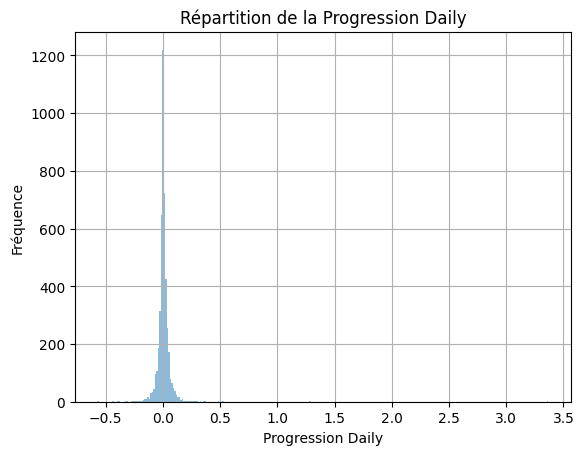

In [213]:
# Affichage de l'histogramme de la progression quotidienne
plt.hist(btc_data['progression daily'].dropna(), bins=300, alpha=0.5)
plt.title('Répartition de la Progression Daily')
plt.xlabel('Progression Daily')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

In [214]:
print(btc_data['progression daily'].describe())

count    4673.000000
mean        0.004238
std         0.072861
min        -0.572057
25%        -0.013633
50%         0.001475
75%         0.019560
max         3.368390
Name: progression daily, dtype: float64


In [215]:
#supprimer la première ligne (NaN)
btc_data = btc_data.drop(btc_data.index[0])

In [216]:
missing_values_sum = btc_data.isna().sum()

In [217]:
missing_values_sum

high                      0
low                       0
open                      0
volumefrom                0
volumeto                  0
close                     0
market_cap              851
progression daily         0
progression tomorrow      0
dtype: int64

In [ ]:
"""btc_data.loc[btc_data['market_cap'].isna()]"""

,price,market_cap,progression daily,progression tomorrow,volumeto
2017-04-02,1098.068,NaN,0.011808,0.037557,77853933.84


In [ ]:
"""missing_index = btc_data.loc[btc_data['market_cap'].isna()].index[0]

# Obtenir la position de l'index manquant
missing_pos = btc_data.index.get_loc(missing_index)

# Définir les positions de début et de fin pour l'extraction des données
start_pos = max(0, missing_pos - 3)
end_pos = min(len(btc_data), missing_pos + 4)

# Afficher les 3 lignes avant et après la valeur manquante
subset_btc_data = btc_data.iloc[start_pos:end_pos]
subset_btc_data"""

,price,market_cap,progression daily,progression tomorrow,volumeto
2017-03-30,1031.492906,1.675784e+10,-0.006859,0.045353,7.763388e+07
2017-03-31,1078.274711,1.751958e+10,0.045353,0.006472,9.654392e+07
2017-04-01,1085.253000,1.763483e+10,0.006472,0.011808,5.502008e+07
2017-04-02,1098.068000,NaN,0.011808,0.037557,7.785393e+07
2017-04-03,1139.308275,1.851790e+10,0.037557,0.001044,1.118708e+08
2017-04-04,1140.497590,1.853906e+10,0.001044,-0.007153,8.116409e+07
2017-04-05,1132.339905,1.840873e+10,-0.007153,0.054640,7.833557e+07


In [ ]:
"""# Trouver l'index de la valeur manquante
missing_index = btc_data.loc[btc_data['market_cap'].isna()].index[0]

# Obtenir la position de l'index manquant
missing_pos = btc_data.index.get_loc(missing_index)

# Calculer la moyenne des valeurs de 'market_cap' qui entourent la valeur manquante
mean_value = (btc_data['market_cap'].iloc[missing_pos - 1] + btc_data['market_cap'].iloc[missing_pos + 1]) / 2

# Remplacer la valeur manquante par la moyenne calculée
btc_data['market_cap'].iloc[missing_pos] = mean_value"""

In [218]:
# Créer une variable cible binaire : 1 si la progression demain est positive, 0 sinon
btc_data['target'] = np.where(btc_data['progression tomorrow'] > 0, 1, 0)

In [219]:
btc_data['target'].describe()

count    4673.000000
mean        0.524716
std         0.499442
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

In [220]:
btc_data.to_csv('data/btc_data')

In [222]:
import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import time

# Configurer l'objet pytrends
pytrends = TrendReq()

kw_list = ["Bitcoin"]

# Liste des périodes
timeframes = ['2013-04-28 2018-04-27', '2018-04-28 2023-04-27']

temp = []

for timeframe in timeframes:
    pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo='', gprop='')
    temp.append(pytrends.interest_over_time())
    #time.sleep(random.randint(10, 20))  # Ajoute une pause de X secondes entre chaque requête

2023-10-16
            Bitcoin  isPartial
date                          
2013-04-28        0      False
2013-05-05        0      False
2013-05-12        0      False
2013-05-19        0      False
2013-05-26        0      False
...             ...        ...
2023-10-08       52      False
2023-10-09       59      False
2023-10-10       60      False
2023-10-11       53      False
2023-10-12       59      False

[690 rows x 2 columns]


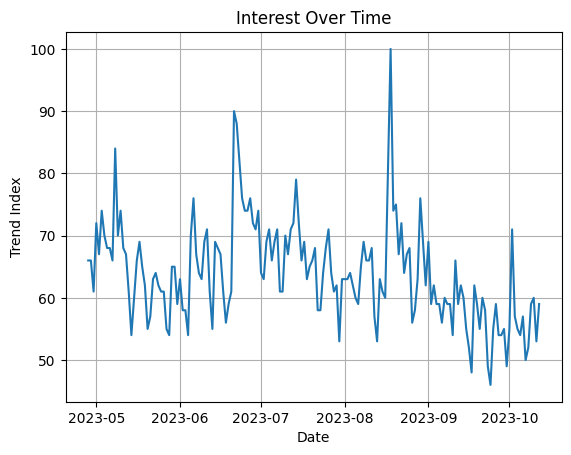

In [223]:
import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as pltdatetime
from datetime import date

current_date = date.today()
formatted_date = current_date.strftime('%Y-%m-%d')
print(formatted_date)

# Configurer l'objet pytrends
pytrends = TrendReq(hl='en-US', tz=360)

# Définir la requête
kw_list = ["Bitcoin"]
pytrends.build_payload(kw_list, cat=0, timeframe='2023-04-28 ' + formatted_date, geo='', gprop='')

# Récupérer les données
df = pytrends.interest_over_time()
temp.append(df)

# Concaténer les dataframes
trends = pd.concat(temp, axis=0)

# Afficher les données
print(trends)


# Visualiser les données
plt.plot(df.index, df['Bitcoin'])
plt.title('Interest Over Time')
plt.xlabel('Date')
plt.ylabel('Trend Index')
plt.grid(True)
plt.show()

In [224]:
btc_data.columns

Index(['high', 'low', 'open', 'volumefrom', 'volumeto', 'close', 'market_cap',
       'progression daily', 'progression tomorrow', 'target'],
      dtype='object')

In [226]:
#Calcul EMA 26

# Choix du nombre de périodes pour l'EMA. Habituellement, 12, 26 ou 50 sont utilisés.
n = 26
alpha = 2 / (n + 1)

# Calcul de l'EMA
btc_data['ema_26'] = btc_data['open'].ewm(span=n, adjust=False).mean()

#Calcul EMA 12

# Choix du nombre de périodes pour l'EMA. Habituellement, 12, 26 ou 50 sont utilisés.
n = 12
alpha = 2 / (n + 1)

# Calcul de l'EMA
btc_data['ema_12'] = btc_data['open'].ewm(span=n, adjust=False).mean()

# Afficher le dataframe
btc_data.tail()

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12
time,,,,,,,,,,,,
2023-10-12,26937.98,26549.78,26871.21,16400.37,4.385320e+08,26756.23,5.236564e+11,-0.019134,-0.004279,0,27159.054405,27392.251948
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287
2023-10-16,30009.15,27131.48,27177.41,47999.44,1.353614e+09,28214.79,5.296435e+11,0.012024,0.000000,0,27097.032155,27171.610705


In [227]:
# Calcul du MACD
btc_data['macd'] = btc_data['ema_12'] - btc_data['ema_26']

btc_data.tail()

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd
time,,,,,,,,,,,,,
2023-10-12,26937.98,26549.78,26871.21,16400.37,4.385320e+08,26756.23,5.236564e+11,-0.019134,-0.004279,0,27159.054405,27392.251948,233.197544
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360
2023-10-16,30009.15,27131.48,27177.41,47999.44,1.353614e+09,28214.79,5.296435e+11,0.012024,0.000000,0,27097.032155,27171.610705,74.578550


In [228]:
# Calcul du RSI 

# Calculer la différence de prix par rapport à la journée précédente
btc_data['delta'] = btc_data['open'].diff()

# Identifier les gains et les pertes
btc_data['gain'] = btc_data['delta'].where(btc_data['delta'] > 0, 0)
btc_data['loss'] = -btc_data['delta'].where(btc_data['delta'] < 0, 0)

# Calculer la moyenne des gains et des pertes sur 14 jours
rolling_window = 14
btc_data['avg_gain'] = btc_data['gain'].rolling(window=rolling_window).mean()
btc_data['avg_loss'] = btc_data['loss'].rolling(window=rolling_window).mean()

# Calculer le RS (Relative Strength)
btc_data['rs'] = btc_data['avg_gain'] / btc_data['avg_loss']

# Calculer le RSI
btc_data['rsi'] = 100 - (100 / (1 + btc_data['rs']))

# Supprimer les colonnes intermédiaires
btc_data.drop(columns=['delta', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs'], inplace=True)

btc_data.tail()

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi
time,,,,,,,,,,,,,,
2023-10-12,26937.98,26549.78,26871.21,16400.37,4.385320e+08,26756.23,5.236564e+11,-0.019134,-0.004279,0,27159.054405,27392.251948,233.197544,55.285920
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891
2023-10-16,30009.15,27131.48,27177.41,47999.44,1.353614e+09,28214.79,5.296435e+11,0.012024,0.000000,0,27097.032155,27171.610705,74.578550,38.382575


In [229]:
# Calcul du volume relatif

# Période pour calculer la moyenne du volume
rolling_window = 14

# Calculer la moyenne du volume sur la période donnée
btc_data['avg_volume'] = btc_data['volumeto'].rolling(window=rolling_window).mean()

# Calculer le volume relatif
btc_data['relative_volume'] = btc_data['volumeto'] / btc_data['avg_volume']

# Supprimer la colonne de volume moyen intermédiaire si désiré
btc_data.drop(columns=['avg_volume'], inplace=True)

btc_data.tail()


,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume
time,,,,,,,,,,,,,,,
2023-10-12,26937.98,26549.78,26871.21,16400.37,4.385320e+08,26756.23,5.236564e+11,-0.019134,-0.004279,0,27159.054405,27392.251948,233.197544,55.285920,0.789286
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745
2023-10-16,30009.15,27131.48,27177.41,47999.44,1.353614e+09,28214.79,5.296435e+11,0.012024,0.000000,0,27097.032155,27171.610705,74.578550,38.382575,2.480502


In [230]:
# Calcul de l'OBV (On-Balance Volume)

# Calculer la direction du mouvement des prix
btc_data['price_direction'] = btc_data['open'].diff()

# Calculer l'OBV
btc_data['obv'] = btc_data['volumeto'].where(btc_data['price_direction'] > 0, -btc_data['volumeto']).cumsum()

# Supprimer la colonne intermédiaire de direction des prix
btc_data.drop(columns=['price_direction'], inplace=True)

btc_data.tail()


,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv
time,,,,,,,,,,,,,,,,
2023-10-12,26937.98,26549.78,26871.21,16400.37,4.385320e+08,26756.23,5.236564e+11,-0.019134,-0.004279,0,27159.054405,27392.251948,233.197544,55.285920,0.789286,1.142354e+10
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417,1.092676e+10
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510,1.108445e+10
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745,1.078734e+10
2023-10-16,30009.15,27131.48,27177.41,47999.44,1.353614e+09,28214.79,5.296435e+11,0.012024,0.000000,0,27097.032155,27171.610705,74.578550,38.382575,2.480502,1.214095e+10


In [232]:
# Calcul de l'ATR (Average True Range)

# Calculer la différence de prix de clôture par rapport à la journée précédente
btc_data['prev_close'] = btc_data['open'].shift(1)

# Calculer les trois composantes du True Range
btc_data['high_minus_low'] = btc_data['high'] - btc_data['low']
btc_data['high_minus_prev_close'] = abs(btc_data['high'] - btc_data['prev_close'])
btc_data['low_minus_prev_close'] = abs(btc_data['low'] - btc_data['prev_close'])

# Déterminer le True Range comme étant le maximum des trois valeurs précédentes
btc_data['tr'] = btc_data[['high_minus_low', 'high_minus_prev_close', 'low_minus_prev_close']].max(axis=1)

# Calculer l'ATR comme étant la moyenne mobile du TR sur une période de 14 jours
rolling_window = 14
btc_data['atr'] = btc_data['tr'].rolling(window=rolling_window).mean()

# Supprimer les colonnes intermédiaires
columns_to_drop = ['prev_close', 'high_minus_low', 'high_minus_prev_close', 'low_minus_prev_close', 'tr']
btc_data.drop(columns=columns_to_drop, inplace=True)

btc_data.tail()

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr
time,,,,,,,,,,,,,,,,,
2023-10-12,26937.98,26549.78,26871.21,16400.37,4.385320e+08,26756.23,5.236564e+11,-0.019134,-0.004279,0,27159.054405,27392.251948,233.197544,55.285920,0.789286,1.142354e+10,816.575714
2023-10-13,27110.91,26674.97,26756.23,18507.04,4.967794e+08,26862.90,5.216077e+11,-0.004279,0.003987,1,27129.215560,27294.402418,165.186858,46.835697,0.904417,1.092676e+10,785.304286
2023-10-14,26982.78,26810.02,26862.90,5865.21,1.576854e+08,26854.52,5.236556e+11,0.003987,-0.000312,0,27109.488482,27228.017431,118.528949,49.455572,0.288510,1.108445e+10,786.607857
2023-10-15,27297.26,26813.06,26854.52,10978.68,2.971100e+08,27177.41,5.239792e+11,-0.000312,0.012024,1,27090.601927,27170.556287,79.954360,48.700891,0.555745,1.078734e+10,738.972857
2023-10-16,30009.15,27131.48,27177.41,47999.44,1.353614e+09,28214.79,5.296435e+11,0.012024,0.000000,0,27097.032155,27171.610705,74.578550,38.382575,2.480502,1.214095e+10,848.527857


In [233]:
btc_data.to_csv('data/btc_data.csv')